# sspa tutorial: Single sample pathway analysis in Python

In [ ]:
!pip install sspa

In [1]:
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load and process metabolomics data

Pre-processing example COVID mass spectrometry dataset

In [10]:
covid_data = sspa.load_example_data(omicstype="metabolomics", processed=False)

In [11]:
covid_values = covid_data.iloc[:, :-2]
data_filt = covid_values.loc[:, covid_values.isin([' ', np.nan, 0]).mean() < 0.5]

met_median = data_filt.median(axis=0, skipna=True)  # median value for each metabolite
scale_mat = data_filt.divide(met_median, axis=1)  # scale the matrix by the metabolite median
samp_median = scale_mat.median(axis=1, skipna=True)  # median value for each sample
norm_mat = data_filt.divide(samp_median, axis=0)  # scale by sample median

imputed_mat = norm_mat.fillna(norm_mat.median())
log2_mat = np.log2(imputed_mat)
processed_data = pd.DataFrame(StandardScaler().fit_transform(log2_mat), columns=imputed_mat.columns, index=imputed_mat.index)

In [12]:
processed_data.head()

,S-1-pyrroline-5-carboxylate,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-hydroxyisobutyrate,3-hydroxy-3-methylglutarate,homovanillate (HVA),3-phosphoglycerate,...,"bilirubin degradation product, C16H18N2O5 (2)**","bilirubin degradation product, C17H18N2O4 (1)**","bilirubin degradation product, C17H18N2O4 (2)**","bilirubin degradation product, C17H18N2O4 (3)**","bilirubin degradation product, C17H20N2O5 (1)**","bilirubin degradation product, C17H20N2O5 (2)**",tetrahydrocortisol glucuronide,"N,N-dimethyl-pro-pro",oxindolylalanine,tetrahydrocortisone glucuronide (5)
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.756979,0.552163,-0.317382,0.726321,-0.608606,-0.815994,-1.783925,-1.367964,-0.196991,-0.128764,...,-0.082822,-0.008485,0.073663,0.163788,-0.209951,-0.221960,0.143159,-0.830118,-0.846009,0.538409
1008097,0.079818,-0.839393,0.491280,-1.867786,-0.044496,-0.390190,-0.293450,-1.008025,-0.115982,-1.042743,...,0.025147,0.286299,0.114470,0.214872,-0.252672,-0.389336,0.299374,-0.278807,0.640936,0.931221
1008631,0.978372,-1.281277,-0.199487,0.355229,0.014784,-0.447509,-0.004413,1.236799,-0.516527,-1.008731,...,0.887881,0.120373,0.559326,0.579894,0.475454,0.392656,0.788248,-0.089581,0.633529,0.347035
1012545,-0.937540,-0.242391,1.636530,2.080704,-0.315610,0.111717,-0.148053,0.127448,-0.115982,-1.238096,...,1.080541,0.811562,0.682729,0.549101,0.416711,0.212145,-0.916428,-0.300312,1.123716,-0.077702
1022407,-0.652496,-0.110733,0.814461,-0.886903,0.409608,0.274345,0.774593,-0.497736,-0.115982,-1.023649,...,0.439088,0.970306,0.852974,0.835494,0.220687,0.197174,0.361032,-0.463056,0.196806,0.671461


OPTIONAL: Save the processed data to cvs format

processed_data.to_csv("example_covid_data_processed.csv")

Alternatively, to load the pre-processed dataset, set the argument "processed" to True

In [ ]:
covid_data_processed = sspa.load_example_data(omicstype="metabolomics", processed=True)

## Identifier harmonisation

Use the identifier_conversion function to get identifier mappings. Change the input_type argument to the type of compound identifier you are converting from. This step may take a few minutes to complete.

In [13]:
compound_names = processed_data.columns.tolist()
conversion_table = sspa.identifier_conversion(input_type="name", compound_list=compound_names)

In [14]:
conversion_table

,Query,Match,HMDB,PubChem,ChEBI,KEGG,METLIN,SMILES,Comment
0,S-1-pyrroline-5-carboxylate,NA,NA,NA,NA,NA,NA,NA,0
1,spermidine,Spermidine,HMDB0001257,1102,16610,C00315,254,NCCCCNCCCN,1
2,1-methylnicotinamide,1-Methylnicotinamide,HMDB0000699,457,16797,C02918,5667,C[N+]1=CC=CC(=C1)C(N)=O,1
3,"12,13-DiHOME","12,13-DHOME",HMDB0004705,10236635,72665,C14829,None,CCCCCC(C(C/C=C\CCCCCCCC(=O)O)O)O,1
4,alpha-ketoglutarate,Oxoglutaric acid,HMDB0000208,51,30915,C00026,5218,OC(=O)CCC(=O)C(O)=O,1
...,...,...,...,...,...,...,...,...,...
895,"bilirubin degradation product, C17H20N2O5 (2)**",NA,NA,NA,NA,NA,NA,NA,0
896,tetrahydrocortisol glucuronide,NA,NA,NA,NA,NA,NA,NA,0
897,"N,N-dimethyl-pro-pro",NA,NA,NA,NA,NA,NA,NA,0
898,oxindolylalanine,NA,NA,NA,NA,NA,NA,NA,0


Count how many identifiers have matches

In [15]:
conversion_table["Comment"].value_counts()

0    547
1    353
Name: Comment, dtype: int64

In [16]:
processed_data_mapped = sspa.map_identifiers(conversion_table, output_id_type="ChEBI", matrix=processed_data)

In [17]:
processed_data_mapped

,16610,16797,72665,30915,18344,37373,16831,17050,16359,18101,...,64032,133677,133693,133694,28036,28238,76341,89312,17861,89188
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.552163,-0.317382,0.726321,-0.608606,-0.815994,-1.783925,-1.367964,-0.128764,-0.976062,-0.180645,...,0.698165,0.379316,0.293833,0.463559,-0.932831,-0.497137,-0.086215,-0.677852,-1.211516,0.544982
1008097,-0.839393,0.491280,-1.867786,-0.044496,-0.390190,-0.293450,-1.008025,-1.042743,1.087097,-0.142179,...,-0.001161,0.806867,0.694447,0.696535,0.166355,0.061275,-0.908010,-1.860243,-0.494520,0.296802
1008631,-1.281277,-0.199487,0.355229,0.014784,-0.447509,-0.004413,1.236799,-1.008731,-0.674438,-0.142179,...,-0.995114,0.673180,0.654255,0.987011,0.376914,0.581169,-1.309510,-0.057694,1.203206,-0.583187
1012545,-0.242391,1.636530,2.080704,-0.315610,0.111717,-0.148053,0.127448,-1.238096,-1.303566,-0.142179,...,0.291436,0.022498,0.161023,0.080969,-0.354917,1.503159,0.782149,-0.444072,0.061354,-0.141750
1022407,-0.110733,0.814461,-0.886903,0.409608,0.274345,0.774593,-0.497736,-1.023649,-0.602467,-0.142179,...,-0.001161,0.715905,0.447427,0.913464,-1.037644,-0.465360,-1.202589,-0.057694,-1.004384,0.062327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135-BL,0.107325,1.907765,-0.071532,0.416002,1.178623,0.930968,0.041873,0.404479,-0.224810,-0.142179,...,-0.533202,-0.180060,-0.324592,-0.235230,-0.168575,0.772554,-0.216535,-0.062482,1.355460,-1.286870
INCOV136-BL,1.449115,-0.192375,-0.071532,-0.469999,-0.988020,1.278558,0.510114,1.740470,1.195814,-0.595542,...,0.684258,-0.364671,-0.705684,-0.746311,-0.164621,-1.691772,0.529092,-0.295279,1.193723,-0.751587
INCOV137-BL,0.555251,0.411375,-0.071532,-1.964391,2.809565,0.797287,0.545391,0.663533,-1.557352,0.323058,...,-0.001161,-2.926096,-2.952633,-2.438364,1.981653,0.949535,0.567135,-0.197493,0.393815,-1.549920


## Importing pathways

Sspa comes with pre-loaded versions of Reactome (all supported organisms) release 78 (2022) and KEGG (human) release 98 (2022). It also allows users to easily download the latest version of KEGG and Reactome (all supported organisms). Users can also provide their own pathway files, as long as they are in GMT format. 

The sspa package has several functions for processing data for different databases. These are:
-	Process_reactome(organism, infile=None, download_latest=False, filepath=None)
-	Process_kegg(organism, infile=None, download_latest=False, filepath=None)
-	Process_gmt(infile)

For KEGG and Reactome, you will need to specify the organism code/name in the function call. KEGG 3-letter organism codes e.g. “hsa”, “mmu”, can be found at http://rest.kegg.jp/list/organism. Reactome organism names e.g. “Homo sapiens”, “Mus musculus”, can be found at https://reactome.org/content/schema/objects/Species. 


Import the pre-loaded Reactome metabolic pathways (Release 78)

In [19]:
# We will import the metabolite pathways from the Reactome database
# We must specify one of the Reactome organism names
# This a GMT format pandas DataFrame containing the pathway information
reactome_pathways  = sspa.process_reactome(organism="Homo sapiens")

In [20]:
kegg_human_pathways  = sspa.process_kegg(organism="hsa")

In [21]:
reactome_pathways.head()

,Pathway_name,0,1,2,3,4,5,6,7,8,...,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477
R-HSA-1059683,Interleukin-6 signaling,30616,456216,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109581,Apoptosis,61120,4705,456216,28494,36080,15377,43474,30616,16412,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109582,Hemostasis,15366,91144,15377,15378,15379,456215,456216,35366,37941,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109606,Intrinsic Pathway for Apoptosis,456216,28494,36080,15377,43474,30616,None,None,None,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109703,PKB-mediated events,456216,16618,17489,15377,456215,30616,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [22]:
kegg_human_pathways.head()

,Pathway_name,0,1,2,3,4,5,6,7,8,...,316,317,318,319,320,321,322,323,324,325
hsa00010,Glycolysis / Gluconeogenesis - Homo sapiens (h...,C00221,C15972,C01159,C00267,C06188,C06187,C00022,C01451,C00118,...,None,None,None,None,None,None,None,None,None,None
hsa00020,Citrate cycle (TCA cycle) - Homo sapiens (human),C15972,C00026,C00022,C05125,C00024,C16255,C00122,C00417,C00158,...,None,None,None,None,None,None,None,None,None,None
hsa00030,Pentose phosphate pathway - Homo sapiens (human),C03752,C00221,C01801,C00257,C00258,C20589,C00121,C00620,C00022,...,None,None,None,None,None,None,None,None,None,None
hsa00040,Pentose and glucuronate interconversions - Hom...,C20680,C06441,C00508,C04575,C00474,C00714,C00532,C05411,C00026,...,None,None,None,None,None,None,None,None,None,None
hsa00051,Fructose and mannose metabolism - Homo sapiens...,C01721,C00424,C00976,C00096,C00267,C00159,C01099,C11544,C01934,...,None,None,None,None,None,None,None,None,None,None


In [7]:
# load custom gmt file
custom_pathways = sspa.process_gmt("src/sspa/pathway_databases/KEGG_human_pathways_compounds_R98.csv")

In [5]:
# custom_pathways_gmt = sspa.process_gmt("/Users/cw2019/Downloads/ReactomePathways.gmt")
custom_pathways_gmt = sspa.process_gmt("/Users/cw2019/Downloads/Mouse_Human_Reactome_February_01_2022_symbol.gmt")

In [6]:
custom_pathways_gmt

,Pathway_name,2,3,4,5,6,7,8,9,10,...,2315,2316,2317,2318,2319,2320,2321,2322,2323,2324
Pathway_ID,,,,,,,,,,,,,,,,,,,,,
LONG-TERM POTENTIATION%REACTOME%R-HSA-9620244.2,Long-term potentiation,Grin2a,Src,Nrg1,Nrgn,Camk2g,Camk2d,Dlg1,Camk2b,Gria2,...,None,None,None,None,None,None,None,None,None,None
GLYCEROPHOSPHOLIPID BIOSYNTHESIS%REACTOME%R-HSA-1483206.4,Glycerophospholipid biosynthesis,Lclat1,Plaat5,Pla2g6,Agk,Etnk1,Lpin3,Chpt1,Lpin2,Pctp,...,None,None,None,None,None,None,None,None,None,None
REGULATION OF PLK1 ACTIVITY AT G2 M TRANSITION%REACTOME%R-HSA-2565942.1,Regulation of PLK1 Activity at G2 M Transition,Nedd1,Actr1a,Haus7,Tuba1a,Haus8,Clasp1,Cdk5rap2,Pafah1b1,Ywhag,...,None,None,None,None,None,None,None,None,None,None
SUMOYLATION OF INTRACELLULAR RECEPTORS%REACTOME%R-HSA-4090294.3,SUMOylation of intracellular receptors,Nr2c1,Vdr,Sumo3,Nr1h2,Rora,Ppara,Esr1,Pparg,Pias3,...,None,None,None,None,None,None,None,None,None,None
PHOSPHORYLATION OF THE APC C%REACTOME%R-HSA-176412.3,Phosphorylation of the APC C,Cdc23,Anapc15,Plk1,Anapc5,Anapc4,Anapc1,Anapc2,Anapc11,Ube2c,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ABACAVIR TRANSPORT AND METABOLISM%REACTOME%R-HSA-2161522.2,Abacavir transport and metabolism,Slc22a2,Slc22a1,Nt5c2,Guk1,Adal,Slc22a3,Pck1,Abcb1a,Abcg2,...,None,None,None,None,None,None,None,None,None,None
SIGNALING BY WNT%REACTOME%R-HSA-195721.5,Signaling by WNT,Gng3,Gng2,Gng4,Gng7,Gng8,Gngt1,Gngt2,Gnb2,Gnb1,...,None,None,None,None,None,None,None,None,None,None
ACTIVATION OF ANTERIOR HOX GENES IN HINDBRAIN DEVELOPMENT DURING EARLY EMBRYOGENESIS%REACTOME%R-HSA-5617472.2,Activation of anterior HOX genes in hindbrain ...,Pcgf2,Kmt2d,Kmt2c,Hist2h2aa1,Pagr1a,Paxip1,Yy1,Pax6,Cnot9,...,None,None,None,None,None,None,None,None,None,None


Download KEGG pathways

In [8]:
kegg_mouse_latest = sspa.process_kegg("mmu", download_latest=True, filepath=".")

Beginning KEGG download...
KEGG DB file saved to ./KEGG_mmu_pathways_compounds_R101.gmt
Complete!


In [2]:
# download Reactome latest
reactome_mouse_latest = sspa.process_reactome("Mus musculus", download_latest=True, filepath=".")

Beginning Reactome download...
Reactome DB file saved to ./Reactome_Mus_musculus_pathways_compounds_R79.gmt
Complete!


In [2]:
reactome_mouse_latest_read = sspa.process_gmt("./Reactome_Mus_musculus_pathways_compounds_R79.gmt")

In [3]:
reactome_mouse_latest_read

,Pathway_name,2,3,4,5,6,7,8,9,10,...,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334
Pathway_ID,,,,,,,,,,,,,,,,,,,,,
R-MMU-1059683,Interleukin-6 signaling,30616,456216,,,,,,,,...,,,,,,,,,,
R-MMU-109581,Apoptosis,61120,4705,456216,28494,15377,43474,30616,16412,,...,,,,,,,,,,
R-MMU-109582,Hemostasis,58115,140420,140421,15366,91144,28938,140427,15627,16783,...,,,,,,,,,,
R-MMU-109606,Intrinsic Pathway for Apoptosis,456216,28494,15377,43474,30616,,,,,...,,,,,,,,,,
R-MMU-109703,PKB-mediated events,17489,15377,456215,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-MMU-983695,Antigen activates B Cell Receptor (BCR) leadin...,456216,16618,18348,36080,16595,29108,17815,30616,,...,,,,,,,,,,
R-MMU-983705,Signaling by the B Cell Receptor (BCR),456216,16618,29034,18348,58189,36080,29105,16595,29108,...,,,,,,,,,,
R-MMU-983712,Ion channel transport,17544,15377,15378,35475,456216,30616,16038,76072,29101,...,,,,,,,,,,


## Single-sample pathway analysis methods

Using kPCA method

In [7]:
kpca_scores = sspa.sspa_kpca(example_data.iloc[:, :-2], reactome_pathways)

In [5]:
# Inspect the pathway score matrix
kpca_scores

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.502078,-0.132625,0.396203,-0.428671,-0.476686,0.441486,0.441486,-0.589968,0.510460,0.510460,...,-0.183712,-0.183712,-0.183712,-0.372311,0.510460,-0.422047,-0.345804,-0.354446,-0.301712,0.591590
1008097,-0.129990,-0.066326,0.391151,-0.406094,-0.518504,0.299533,0.299533,-0.473981,-0.468032,-0.468032,...,-0.338553,-0.338553,-0.338553,0.084853,-0.468032,-0.196016,-0.036367,-0.388074,-0.342489,-0.647908
1008631,-0.440406,-0.635373,0.532148,-0.304056,0.119538,0.409759,0.409759,-0.516610,-0.485141,-0.485141,...,-0.188555,-0.188555,-0.188555,0.253315,-0.485141,0.057013,0.189092,0.005851,-0.006643,-0.637767
1012545,-0.510654,-0.006082,0.194296,-0.233943,-0.137645,0.279338,0.279338,0.483868,0.276672,0.276672,...,-0.360939,-0.360939,-0.360939,-0.462326,0.276672,0.055994,-0.501358,0.281106,0.260653,0.323059
1022407,-0.466940,-0.489754,0.240493,-0.503301,0.237958,0.383802,0.383802,-0.291602,0.375111,0.375111,...,-0.353277,-0.353277,-0.353277,-0.303643,0.375111,-0.457766,-0.327138,-0.439894,-0.356451,0.386204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135-BL,0.413898,0.623289,0.088663,-0.017805,-0.135851,0.161592,0.161592,0.378288,-0.489231,-0.489231,...,-0.303870,-0.303870,-0.303870,0.209797,-0.489231,-0.192039,0.219603,-0.320906,-0.403381,-0.586796
INCOV136-BL,0.301070,0.507104,-0.375875,0.570154,0.009647,-0.375421,-0.375421,0.623957,0.403879,0.403879,...,0.266371,0.266371,0.266371,-0.112053,0.403879,-0.345653,0.095706,-0.320380,-0.319519,0.647968
INCOV137-BL,0.291807,0.629146,-0.329863,0.441748,-0.121469,-0.363859,-0.363859,0.417775,-0.504907,-0.504907,...,-0.022882,-0.022882,-0.022882,0.593205,-0.504907,0.373511,0.230926,0.399491,0.400392,-0.568340


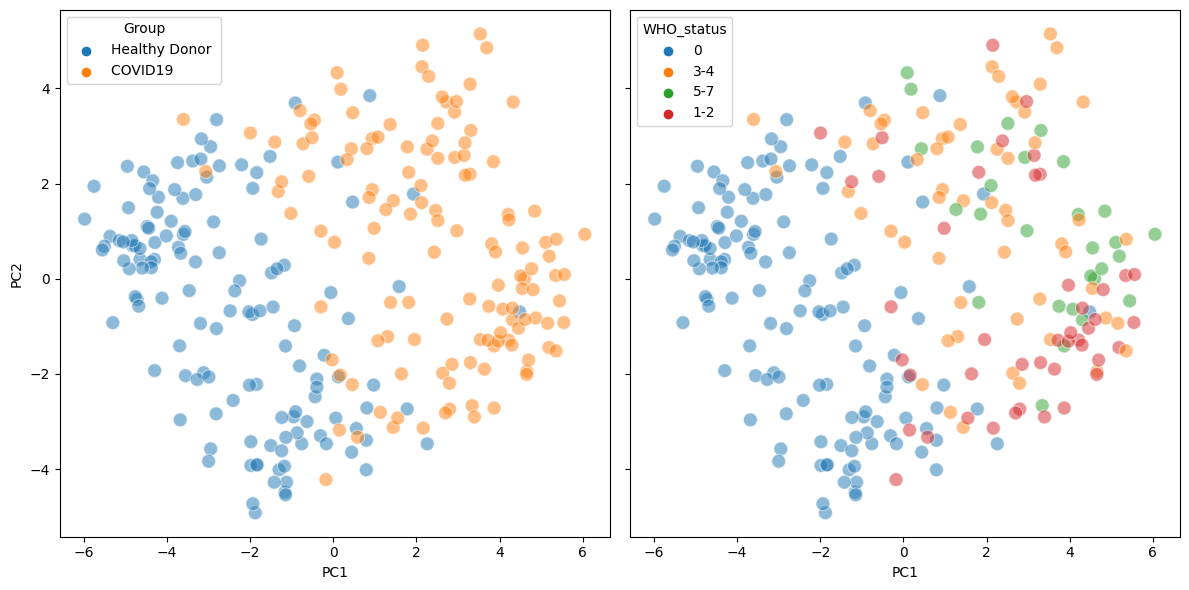

In [29]:
# Pathway-based PCA plot

# Perfom two component PCA using sklearn
pca = PCA(n_components=2).fit_transform(kpca_scores)

# Plot the first two components as a scatterplot
plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
sns.scatterplot(x=pca[:, 0 ], y=pca[:, 1], hue=example_data["Group"], ax=ax1, s=100, alpha=0.5)
sns.scatterplot(x=pca[:, 0 ], y=pca[:, 1], hue=example_data["WHO_status"], ax=ax2, s=100, alpha=0.5)

# Set axis labels 
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.tight_layout()
plt.savefig("/Users/cw2019/Documents/PhD/STAR_protocol/kpca_pca_plots.png", dpi=350, bbox_inches="tight")
plt.show()

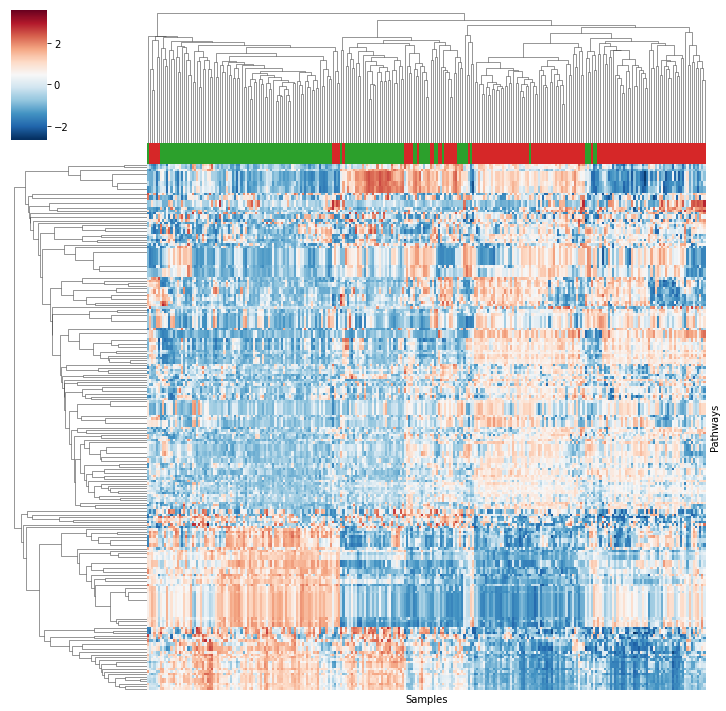

In [10]:
# Plot a heatmap using the pathway scores
g = sns.clustermap(kpca_scores.T,
               cmap="RdBu_r",
               z_score=1,
              col_colors = ["tab:red" if i == "COVID19 " else "tab:green" for i in example_data["Group"]],
              xticklabels=False,
              yticklabels=False)
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Pathways")
plt.savefig("/Users/cw2019/Documents/PhD/STAR_protocol/kpca_heatmap.png", dpi=350, bbox_inches="tight")
plt.show()

<AxesSubplot:xlabel='R-HSA-109582', ylabel='R-HSA-112314'>

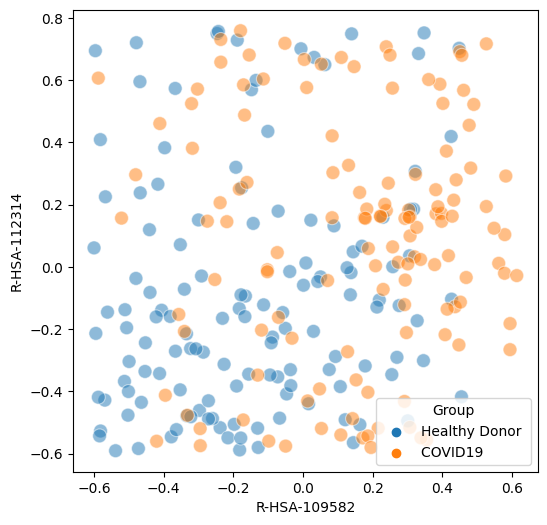

In [34]:
# Plot the first two components as a scatterplot
plt.style.use("default")
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
sns.scatterplot(x=kpca_scores.loc[:, "R-HSA-109582"], y=kpca_scores.loc[:, "R-HSA-112314"], hue=example_data["Group"], ax=ax1, s=100, alpha=0.5)
ax1.se


Using ssClustPA method

In [6]:
ssclustpa_res = sspa.sspa_cluster(example_data.iloc[:, :-2], reactome_pathways)

In [7]:
ssclustpa_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.686092,1.978250,3.054088,2.906924,0.614528,3.150440,3.172926,2.830497,0.577994,1.988715,...,3.412581,1.497666,1.497666,2.027400,0.577994,2.463404,2.303371,0.936432,2.268061,0.513695
1008097,1.227926,1.361079,2.638979,3.729600,0.944724,3.183931,3.219696,2.103014,2.402892,0.577443,...,2.956051,0.994147,0.994147,1.645823,2.402892,2.250756,2.499751,0.951916,2.591363,2.327286
1008631,0.923137,2.446584,1.628949,2.175079,0.216541,1.860208,1.922489,2.417710,2.335157,0.440770,...,2.247359,0.996719,0.996719,1.155750,2.335157,1.135429,1.413791,1.576425,1.669030,2.286247
1012545,1.335768,2.418464,3.171258,3.465990,0.563788,3.817446,3.845707,1.558720,1.726178,1.941054,...,2.783308,0.970014,0.970014,3.045595,1.726178,3.481035,3.342645,2.545888,2.999395,0.867966
1022407,1.424180,1.689955,2.995428,3.092717,0.437969,3.356361,3.373692,1.870197,0.996406,1.585746,...,2.897329,0.776872,0.776872,1.811496,0.996406,2.381307,2.205184,0.653758,2.282944,0.870463


Using ssClustPA(proj) method

In [8]:
ssclustpa_proj_res = sspa.sspa_cluster(example_data.iloc[:, :-2], reactome_pathways, projection=True)
ssclustpa_proj_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-1.138012,0.612266,-1.196473,1.058390,0.231663,1.186966,1.186966,-1.503746,-1.001217,1.001217,...,1.127729,1.127729,1.127729,0.626047,1.003367,1.019928,0.797385,0.264491,0.337755,1.001937
1008097,-1.239243,0.233183,0.821814,2.070620,0.366747,-0.281255,-0.281255,-0.777702,1.102165,-1.102165,...,0.795619,0.795619,0.795619,-0.189060,-1.109737,0.031585,0.359072,1.266075,0.844695,-1.103654
1008631,-0.675104,1.473881,0.650962,0.371524,0.504319,-0.550725,-0.550725,-1.029775,1.061683,-1.061683,...,0.053606,0.053606,0.053606,-0.485135,-1.067348,-1.241347,-0.340290,-0.714006,-0.387968,-1.062813
1012545,-0.966325,0.465256,-1.302114,1.257698,-0.186664,1.566948,1.566948,0.426893,-0.364646,0.364646,...,0.605926,0.605926,0.605926,1.671433,0.342733,0.749489,1.924766,-0.093753,0.319805,0.360651
1022407,-1.303047,0.707896,-1.311350,1.465829,0.759903,1.596556,1.596556,-0.534112,-0.518826,0.518826,...,0.803873,0.803873,0.803873,0.556161,0.513847,0.956530,0.785223,0.788806,0.559682,0.517576


Using z-score method

In [9]:
zscore_res = sspa.sspa_zscore(example_data.iloc[:, :-2], reactome_pathways)

In [10]:
zscore_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.167654,-0.634281,-1.195573,-1.010589,-0.092788,-0.909283,-0.909283,-1.465189,0.658852,0.658852,...,-0.254058,-0.254058,-0.254058,0.588049,0.658852,0.230005,0.164385,-0.386723,-0.427604,0.993357
1008097,-1.397061,-0.245093,-2.396622,-2.046443,-0.147668,-2.395123,-2.395123,-0.769212,-0.583845,-0.583845,...,-0.342975,-0.342975,-0.342975,-0.119131,-0.583845,-0.435729,-0.709389,-0.006923,-0.327141,-1.101735
1008631,0.461736,-1.477089,-1.406400,-0.336006,-0.529297,-1.241239,-1.241239,-0.919933,-0.626855,-0.626855,...,-0.616980,-0.616980,-0.616980,-0.436981,-0.626855,-0.999337,-0.450087,-0.561914,-0.515378,-1.061005
1012545,0.701684,-0.429032,-0.038955,-1.115958,0.160970,-0.316692,-0.316692,0.200689,1.142506,1.142506,...,-0.713366,-0.713366,-0.713366,1.730048,1.142506,0.443188,1.201164,1.027331,1.137367,0.358604
1022407,-0.112825,-0.703408,-0.005595,-1.447454,-0.784849,-0.564315,-0.564315,-0.560817,0.696354,0.696354,...,-0.870950,-0.870950,-0.870950,0.545654,0.696354,-0.014220,0.094409,0.056086,-0.243176,0.526767


Using SVD (PLAGE) method

In [12]:
svd_res = sspa.sspa_svd(example_data.iloc[:, :-2], reactome_pathways)
svd_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.053439,0.034742,-0.024311,0.034779,0.005188,0.023736,0.023736,0.077489,-0.045696,-0.045696,...,-0.021656,-0.021656,-0.021656,-0.043171,-0.045696,-0.038112,-0.050812,-0.015621,-0.017493,-0.044859
1008097,0.063985,0.013425,0.050263,0.087979,0.008256,-0.023342,-0.023342,0.040681,0.051777,0.051777,...,0.005050,0.005050,0.005050,0.062723,0.051777,-0.007703,0.026933,-0.055497,-0.043114,0.049754
1008631,0.028972,0.080906,0.041114,0.013106,0.029592,-0.034629,-0.034629,0.048652,0.049381,0.049381,...,0.019808,0.019808,0.019808,0.051500,0.049381,0.048971,0.041663,0.032112,0.024307,0.047914
1012545,0.042074,0.023500,-0.034746,0.009973,-0.009000,0.026112,0.026112,-0.010614,-0.009740,-0.009740,...,0.032331,0.032331,0.032331,0.028438,-0.009740,-0.036042,-0.036334,-0.003646,-0.021137,-0.016194
1022407,0.067931,0.038528,-0.039728,0.060691,0.043879,0.049868,0.049868,0.029660,-0.021638,-0.021638,...,-0.006885,-0.006885,-0.006885,-0.015345,-0.021638,-0.041113,-0.032891,-0.040322,-0.032426,-0.023788


Using GSVA (Hanzelmann et al)

In [8]:
gsva_res = sspa.sspa_gsva(example_data.iloc[:, :-2], reactome_pathways)
gsva_res.head()

Estimating GSVA scores for 218 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
1004596,0.255705,-0.433279,-0.192992,-0.244877,0.336262,0.067439,0.067439,-0.864048,0.740032,0.740032,...,0.099121,0.099121,0.099121,0.627142,0.740032,0.417393,0.382230,0.155963,0.155488,0.758308
1008097,-0.742172,0.027190,-0.686863,-0.811550,-0.143125,-0.613844,-0.613844,-0.314199,-0.275504,-0.275504,...,0.198443,0.198443,0.198443,0.095580,-0.275504,0.141108,-0.198742,0.259432,0.063042,-0.613293
1008631,0.460962,-0.851964,-0.515119,0.110092,-0.247576,-0.285113,-0.285113,-0.722829,-0.344777,-0.344777,...,-0.035106,-0.035106,-0.035106,-0.219263,-0.344777,-0.185774,-0.180705,-0.087269,-0.106652,-0.628399
1012545,0.295508,-0.228624,-0.149738,-0.407537,0.398691,-0.164639,-0.164639,-0.103485,0.524242,0.524242,...,-0.466324,-0.466324,-0.466324,0.631599,0.524242,0.059310,0.389221,0.654932,0.691236,0.247734
1022407,0.248149,-0.298179,0.372824,-0.512483,-0.383686,0.201426,0.201426,-0.096677,0.553847,0.553847,...,-0.079139,-0.079139,-0.079139,0.522796,0.553847,0.326558,0.232762,0.345912,0.264069,0.543807


## Conventional pathway analysis methods

### ORA

In [13]:
ora_res = sspa.sspa_ora(processed_data_mapped, covid_data["Group"], reactome_pathways, 0.05)

/Users/cw2019/opt/anaconda3/envs/py10/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
ora_res.sort_values(by="P-value")

,ID,Pathway_name,Hits,Coverage,P-value,P-adjust
87,R-HSA-5619115,Disorders of transmembrane transporters,14/14,14/98,0.007630,0.993443
86,R-HSA-5619102,SLC transporter disorders,12/12,12/80,0.015565,0.993443
124,R-HSA-8956321,Nucleotide salvage,8/8,8/45,0.063694,0.993443
26,R-HSA-1643685,Disease,18/21,21/491,0.097410,0.993443
8,R-HSA-1430728,Metabolism,58/76,76/1477,0.162572,0.993443
...,...,...,...,...,...,...
135,R-HSA-9658195,Leishmania infection,1/4,4/58,0.993443,0.993443
136,R-HSA-9660821,ADORA2B mediated anti-inflammatory cytokines p...,1/4,4/21,0.993443,0.993443
137,R-HSA-9662851,Anti-inflammatory response favouring Leishmani...,1/4,4/36,0.993443,0.993443
138,R-HSA-9664433,Leishmania parasite growth and survival,1/4,4/36,0.993443,0.993443


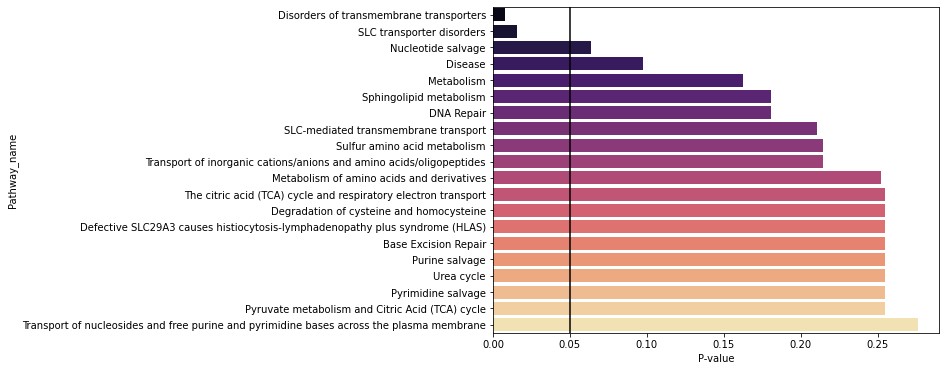

In [43]:
top_20_pathways = ora_res.sort_values(by="P-value").iloc[0:20, :]
plt.figure(figsize=(8, 6))
sns.barplot(data=top_20_pathways, y="Pathway_name", x="P-value", orient="h", palette="magma")
plt.axvline(0.05, c="black")
plt.savefig("ORA_top_20.png", dpi=300, bbox_inches="tight")
plt.show()

### GSEA
Here we use a python wrapper that calls the R package fast GSEA (fGSEA) by Korotkevich et al. 

In [5]:
gsea_res = sspa.sspa_fgsea(example_data.iloc[:, :-2], example_data['Group'], reactome_pathways)

/Users/cw2019/opt/anaconda3/envs/py10/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
gsea_res.sort_values(by="P-value")

,ID,P-value,P-adjust,log2err,ES,NES,coverage,leadingEdge,Pathway_name
175,R-HSA-74217,0.000849,0.185059,0.477271,-0.930091,-1.715901,4,"[17596, 17368, 16708, 16335]",Purine salvage
37,R-HSA-1614635,0.007059,0.413583,0.407018,-0.649061,-1.667295,12,"[16668, 17509, 16708, 16335, 17724, 30831, 158...",Sulfur amino acid metabolism
160,R-HSA-71291,0.016476,0.413583,0.352488,-0.490241,-1.577369,30,"[16668, 15999, 16946, 17509, 17533, 16708, 163...",Metabolism of amino acids and derivatives
104,R-HSA-392499,0.021735,0.413583,0.352488,-0.601406,-1.544880,12,"[17596, 17509, 4208, 16335, 16610]",Metabolism of proteins
119,R-HSA-428157,0.028287,0.413583,0.352488,-0.760622,-1.519768,5,"[16393, 17553, 18132, 16566]",Sphingolipid metabolism
...,...,...,...,...,...,...,...,...,...
67,R-HSA-2046104,0.975439,0.990049,0.040823,-0.380734,-0.579515,2,[16238],alpha-linolenic (omega3) and linoleic (omega6)...
54,R-HSA-192456,0.985507,0.990049,0.036378,-0.277410,-0.511787,4,[28865],Digestion of dietary lipid
198,R-HSA-8963743,0.985507,0.990049,0.036378,-0.277410,-0.511787,4,[28865],Digestion and absorption
189,R-HSA-8935690,0.985507,0.990049,0.036378,-0.277410,-0.511787,4,[28865],Digestion


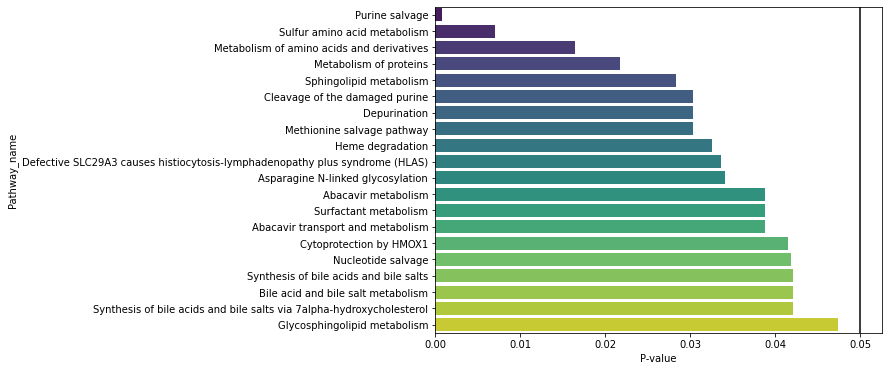

In [7]:
top_20_pathways_gsea = gsea_res.sort_values(by="P-value").iloc[0:20, :]
plt.figure(figsize=(8, 6))
sns.barplot(data=top_20_pathways_gsea, y="Pathway_name", x="P-value", orient="h", palette="viridis")
plt.axvline(0.05, c="black")
plt.savefig("GSEA_top_20.png", dpi=300, bbox_inches="tight")
plt.show()

## Specifying your own data

In [ ]:
# Read in omics data as a pandas DataFrame
mydat = pd.read_csv("")
kpca_scores_2 = sspa.sspa_kpca(mydat, reactome_pathways)

## Specifying your own pathways

In [7]:
custom_pathways = sspa.ProcessPathways('path.csv').process_gmt()

FileNotFoundError: [Errno 2] No such file or directory: 'path.csv'